# Time Series Analysis with Zillow Housing Data

<b>Motivation:</b> With my newly honed skills in time series analysis, I thought this would be the perfect opportunity to discover which zipcode in my hometown of Chicago will be the best investment if I were to move back and purchase real estate. The following notebook demonstrates that journey and ultimately the conclusion of where I could purchase my first home. 

You can find the dataset (and more) <a href='https://www.zillow.com/research/data/'>here. </a>

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 8
matplotlib.rcParams['ytick.labelsize'] = 8
matplotlib.rcParams['text.color'] = 'k'

import geopandas as gpd

In [38]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [39]:
chicago_df = df.query("City == 'Chicago'")
chicago_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


# Step 2: Data Preprocessing

In [41]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [42]:
# getting it down to just the relevant information for time series predictions
to_drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
chicago_df = chicago_df.drop(to_drop, axis=1)
chicago_df.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,60640,216500.0,216700.0,216900.0,217000.0,217100.0,217200.0,217500.0,217900.0,218600.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,60647,122700.0,122800.0,122800.0,122700.0,122400.0,122000.0,121500.0,120900.0,120500.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,60618,142600.0,143100.0,143400.0,143300.0,142900.0,142200.0,141300.0,140100.0,139000.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [43]:
get_datetimes(chicago_df) #Changing column names to pandas datetime format

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

The code below will write new CSVs for each of the chosen zipcodes and create a dictionary where the keys represent the zipcode and the values are the corresponding timeseries dataframe. This new dictionary will help to iterate through each time series dataframe separately. The “RegionName” column holds the zipcodes.

The zipcodes chosen are at the discretion of the stakeholder. 

In [44]:
# writing new CSVs with each Chicago zipcode of choice separately
chosen_zips = [60607, 60661, 60612, 60622, 60642, 60647, 60614, 60625, 60618, 60657, 60608, 60616]

chi_dict = {}
for zipcode, data in chicago_df.groupby('RegionName'):
    
    if zipcode in chosen_zips:
        data.to_csv('{}.csv'.format(zipcode), header=True,      index_label=False)
        
        chi_dict[zipcode] = pd.read_csv('{}.csv'.format(zipcode))
    else:
        continue

In [45]:
chosen_zips & chi_dict.keys()

{60607, 60608, 60612, 60614, 60616, 60618, 60622, 60625, 60642, 60647, 60657}

In [46]:
# helper function to reshape into long format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [47]:
# reshaping dataframes to long format
for zipcode in chi_dict.keys():
    chi_dict[zipcode] = melt_data(chi_dict[zipcode])

# Step 3: EDA and Visualization

In [48]:
# Turning long format dataframes back into a single dataframe for visualizations
for zipcode in chi_dict.keys():
    zip_df = pd.concat(chi_dict, axis = 1)

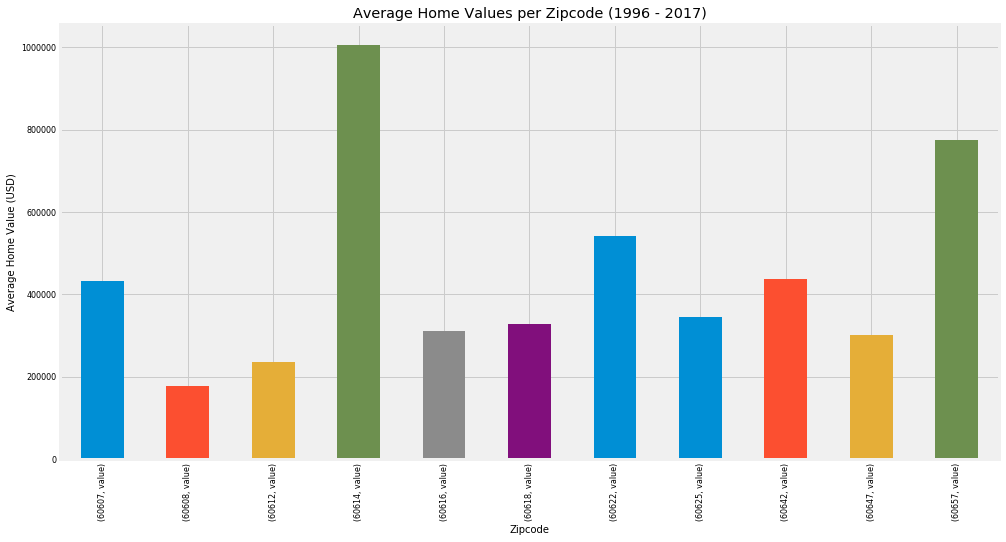

In [70]:
zip_df.median().plot(kind='bar',figsize=(15,8))
plt.title("Average Home Values per Zipcode (1996 - 2017)")
plt.xlabel("Zipcode")
plt.ylabel("Average Home Value (USD)")
plt.plot();

The above bar plot helps assess which of the zipcodes are out of the stakeholder's price range, averaging $400,000 or below. 

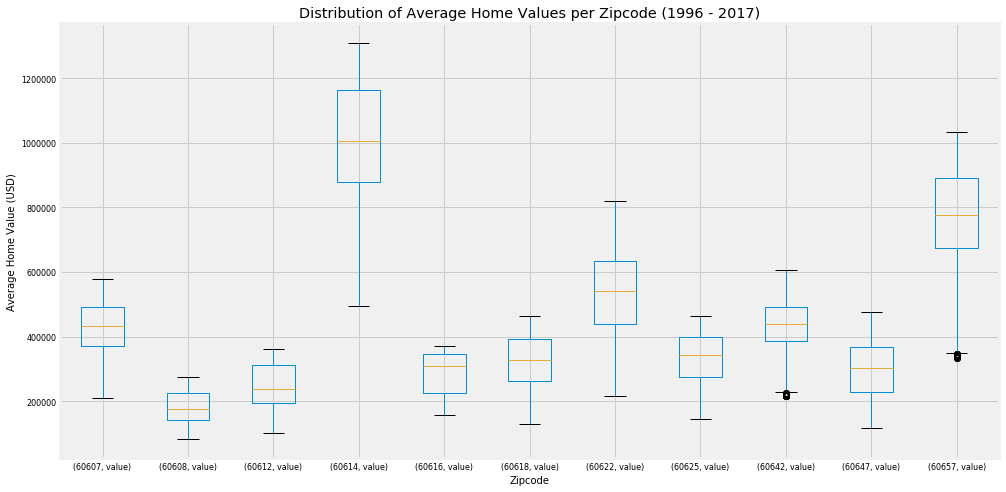

In [13]:
zip_df.boxplot(figsize=(15,8))
plt.title("Distribution of Average Home Values per Zipcode (1996 - 2017)")
plt.xlabel("Zipcode")
plt.ylabel("Average Home Value (USD)")
plt.plot();

Again, the above box plots show distribution for averages, further validating the choice to remove certain zipcodes. There are also few outliers that could affect the integrity of the model later out, so there will not need to be outlier removal.

In [71]:
# Removing zips out of stakeholders price range
for zipcode in [60607,60614,60622,60642,60657]:
    chi_dict.pop(zipcode)

In [72]:
zip_df.drop([60607,60614,60622,60642,60657], axis=1, inplace=True)

In [16]:
norm_zip_df = ((zip_df-zip_df.min())/(zip_df.max()-zip_df.min()))*20 #Normalizing values

Text(0, 0.5, 'Value')

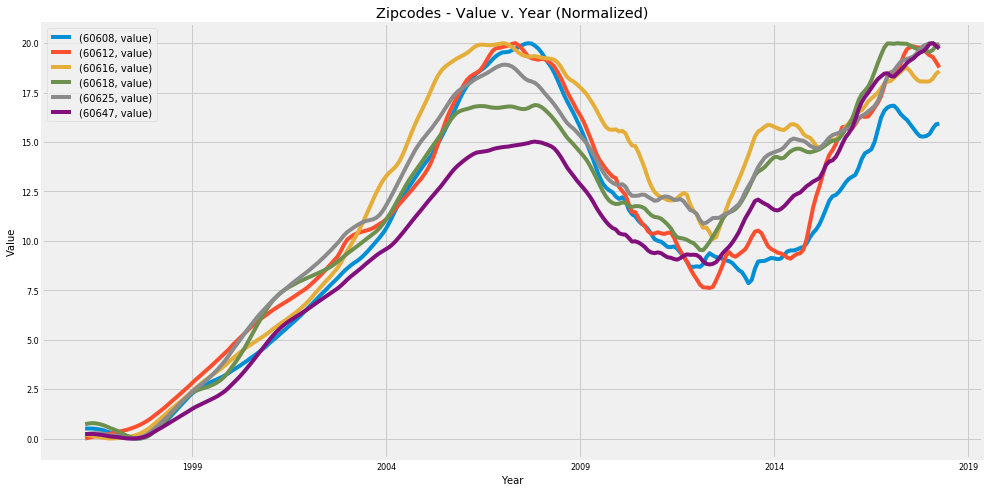

In [17]:
norm_zip_df.plot(figsize=(15,8))
plt.legend()
plt.title(f'Zipcodes - Value v. Year (Normalized)')
plt.xlabel('Year')
plt.ylabel("Value")

We can see a marked drop around the time of the housing bubble burst, and for some of the zipcodes, the values were able to rebound to pre-burst levels. To assess how deeply the burst impacted home values, we can take a look at the percentage change from the peak to the valley after the crash.

In [18]:
for zc in chi_dict:
    crash = chi_dict[zc]['2007':'2013']
    percent_change = (crash.max()-crash.min())/crash.max()
    print(f'{zc} min: {crash.min()} \n {zc} max: {crash.max()} \n Percent change: {percent_change*-100} \n\n')

60608 min: value    159500.0
dtype: float64 
 60608 max: value    274600.0
dtype: float64 
 Percent change: value   -41.915513
dtype: float64 


60612 min: value    200100.0
dtype: float64 
 60612 max: value    361400.0
dtype: float64 
 Percent change: value   -44.631987
dtype: float64 


60616 min: value    265600.0
dtype: float64 
 60616 max: value    370500.0
dtype: float64 
 Percent change: value   -28.31309
dtype: float64 


60618 min: value    289700.0
dtype: float64 
 60618 max: value    412400.0
dtype: float64 
 Percent change: value   -29.752667
dtype: float64 


60625 min: value    318700.0
dtype: float64 
 60625 max: value    446900.0
dtype: float64 
 Percent change: value   -28.686507
dtype: float64 


60647 min: value    275600.0
dtype: float64 
 60647 max: value    386400.0
dtype: float64 
 Percent change: value   -28.674948
dtype: float64 




In [19]:
# Removing zips that dropped over 40% in value
chi_dict.pop(60608)
chi_dict.pop(60612)
norm_zip_df.drop([60608,60612], inplace=True, axis=1)

# Step 5: ARIMA Modeling

The model will be conducted on values from 2011 on as an anomoly such as the housing bubble may affect future predictions.

In [22]:
for zc in chi_dict.keys():
    chi_dict[zc] = chi_dict[zc]['2011':]

We can conduct a “grid search” by iterating over every combinations of the ARIMA models parameters (p, d, and q), including an option for seasonality as donoted by ‘s’.

In [23]:
import itertools 

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In order to optimize for AIC, we’ll model each zipcode with each combination of parameters and place the results into a dataframe.

In [24]:
import warnings
warnings.filterwarnings('ignore')
AIC = []
for zipcode in chi_dict.keys():
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(chi_dict[zipcode],
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False
                                                )
                results = mod.fit()
                AIC.append([zipcode, param, param_seasonal, np.abs(results.aic)])
                
            
            except:
                continue

In [25]:
AIC_df = pd.DataFrame(AIC, columns = ["zip","pdq", "pdqs", 'aic'])

In [26]:
# Dictionary for easy iteration
AIC_dict = {}
for i, g in AIC_df.groupby('zip'):
    AIC_dict[i] = g
    

Below, we'll sort by lowest AIC in order to optimize the model.

In [27]:
for zipcode in AIC_dict.keys():
    AIC_dict[zipcode].sort_values('aic', axis=0, inplace=True)
    AIC_dict[zipcode]=AIC_dict[zipcode].reset_index()
    AIC_dict[zipcode].drop(['index'], axis=1, inplace=True)
   # AIC_dict[zipcode].drop(['level_0'], axis=1, inplace=True)

In [28]:
for zipcode in AIC_dict.keys():
    print(AIC_dict[zipcode].iloc[0:3,:])

     zip        pdq           pdqs          aic
0  60616  (1, 1, 1)  (0, 1, 1, 12)  1047.879682
1  60616  (1, 1, 1)  (1, 1, 1, 12)  1050.947957
2  60616  (1, 1, 0)  (1, 1, 0, 12)  1070.889485
     zip        pdq           pdqs          aic
0  60618  (1, 1, 1)  (1, 1, 1, 12)  1052.221303
1  60618  (1, 1, 1)  (0, 1, 1, 12)  1053.711415
2  60618  (1, 1, 1)  (1, 1, 0, 12)  1072.058478
     zip        pdq           pdqs          aic
0  60625  (1, 1, 1)  (1, 1, 1, 12)  1053.278873
1  60625  (1, 1, 1)  (0, 1, 1, 12)  1054.200742
2  60625  (1, 1, 1)  (1, 1, 0, 12)  1073.396432
     zip        pdq           pdqs          aic
0  60647  (1, 1, 1)  (1, 1, 1, 12)  1090.542431
1  60647  (1, 1, 1)  (0, 1, 1, 12)  1091.352307
2  60647  (1, 1, 1)  (1, 1, 0, 12)  1106.586174


The following list of functions will fit and diagnose the model based on the lowest AIC, plot predictions with a confidence interval, and forecast values three years into the future. 

In [29]:
def SARIMAX_model(zipcode):
    pdq = AIC_dict[zipcode].loc[AIC_dict[zipcode]['aic'].idxmin()]['pdq']
    pdqs = AIC_dict[zipcode].loc[AIC_dict[zipcode]['aic'].idxmin()]['pdqs']
    
    mod = sm.tsa.statespace.SARIMAX(chi_dict[zipcode]['value'],
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    return results

def plot_diagnostics(model, zipcode):
    model.plot_diagnostics(figsize=(16, 8))
    plt.title(zipcode)
    plt.show();
    
def plot_predictions(model, zipcode):
    
    pred = model.get_prediction(start=pd.to_datetime('2015'), dynamic=False) #Get Predictions
    pred_conf = pred.conf_int()
    
    rcParams['figure.figsize'] = 15, 6

    ax = chi_dict[zipcode]['2011':].plot(label='observed')#Plot observed values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)#Plot predicted values

    ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.4)#Plot the range for confidence intervals

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel(f'Home Values for {zipcode}')
    plt.legend()

    plt.show()
    
    forecast = pred.predicted_mean
    real = chi_dict[zipcode]['value']['2015':]

    # Compute the MSE and RMSE
    mse = mean_squared_error(forecast, real)
    rmse = np.sqrt(mse)
    print(f'The Mean Squared Error of our forecasts for {zipcode} is {round(mse, 2)}\n\n')
    print(f'The Root Mean Squared Error of our forecasts for {zipcode} is {round(rmse, 2)}\n\n')
    
def plot_dynamic_forecast(model, zipcode):
    pred_dynamic = model.get_prediction(start=pd.to_datetime('2013'), dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()

# Plot the dynamic forecast with confidence intervals.
    pred = model.get_prediction(start=pd.to_datetime('2015'), dynamic=False)
    forecast = pred.predicted_mean
    real = chi_dict[zipcode]['value']['2015':]

    ax = chi_dict[zipcode]['value']['2011':].plot(label='observed')
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    forecast_dynamic = pred_dynamic.predicted_mean
    real = chi_dict[zipcode]['value']['2013':]
    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2013'), forecast.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Year')
    ax.set_ylabel('Home Value')

    plt.legend()
    plt.show();
    
    mse = mean_squared_error(forecast_dynamic, real)
    rmse = np.sqrt(mse)
    print(f'The Mean Squared Error of our forecasts for {zipcode} is {round(mse, 2)}\n\n')
    print(f'The Root Mean Squared Error of our forecasts for {zipcode} is {round(rmse, 2)}\n\n')
    
def plot_forecast(model, zipcode):
    prediction = model.get_forecast(steps=36)


    pred_conf = prediction.conf_int()
    ax = chi_dict[zipcode]['value'].plot(label='observed', figsize=(17, 15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Year')
    ax.set_ylabel('Home Value')

    plt.legend()
    plt.show()
    
def time_series_results(model, zipcode):
    print(model.summary())
    plot_diagnostics(model, zipcode)
    plot_predictions(model, zipcode)
    plot_dynamic_forecast(model, zipcode)
    plot_forecast(model, zipcode)

In [30]:
model_60647 = SARIMAX_model(60647)
model_60616 = SARIMAX_model(60616)
model_60618 = SARIMAX_model(60618)
model_60625 = SARIMAX_model(60625)

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                   88
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -540.271
Date:                            Wed, 23 Oct 2019   AIC                           1090.542
Time:                                    17:30:07   BIC                           1101.097
Sample:                                01-01-2011   HQIC                          1094.679
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6595      0.124      5.308      0.000       0.416       0.903
ma.L1          0.8941      0.104   

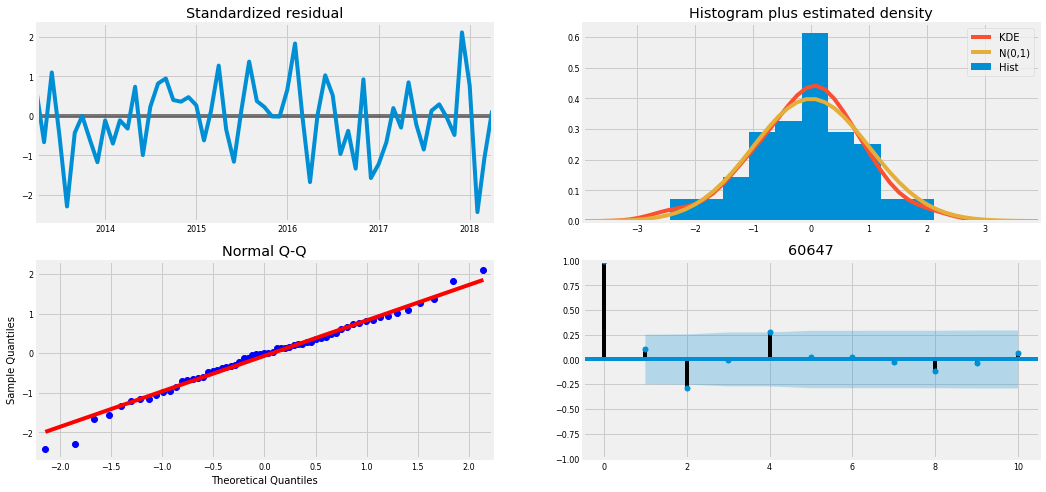

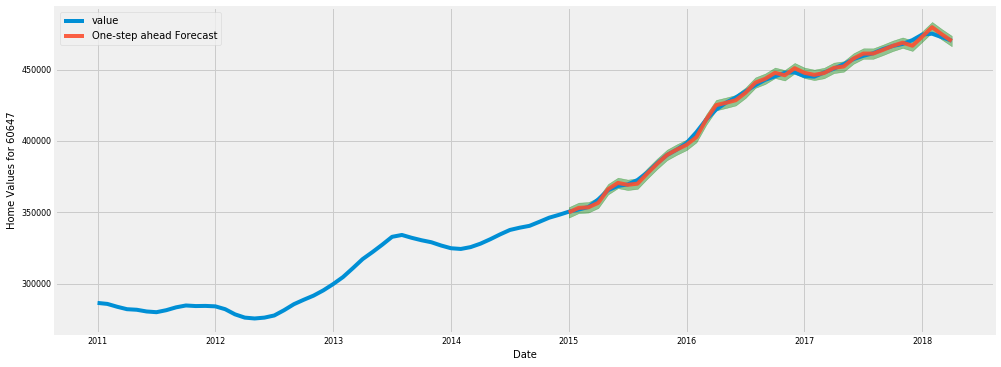

The Mean Squared Error of our forecasts for 60647 is 3115463.44


The Root Mean Squared Error of our forecasts for 60647 is 1765.07




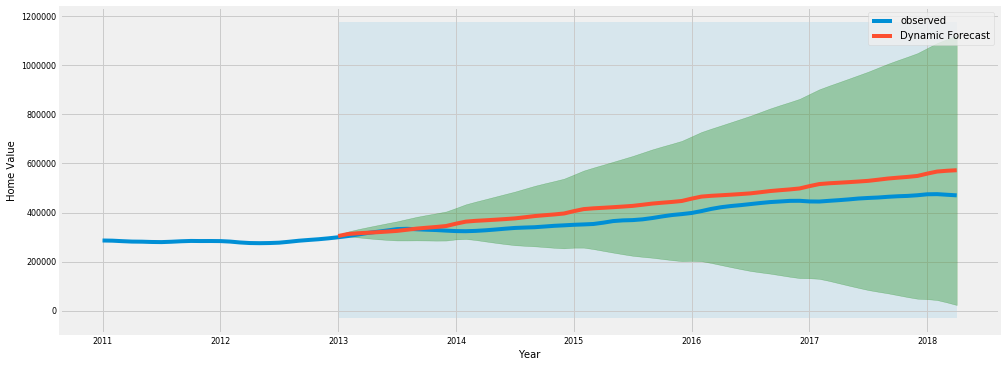

The Mean Squared Error of our forecasts for 60647 is 2942616843.19


The Root Mean Squared Error of our forecasts for 60647 is 54245.89




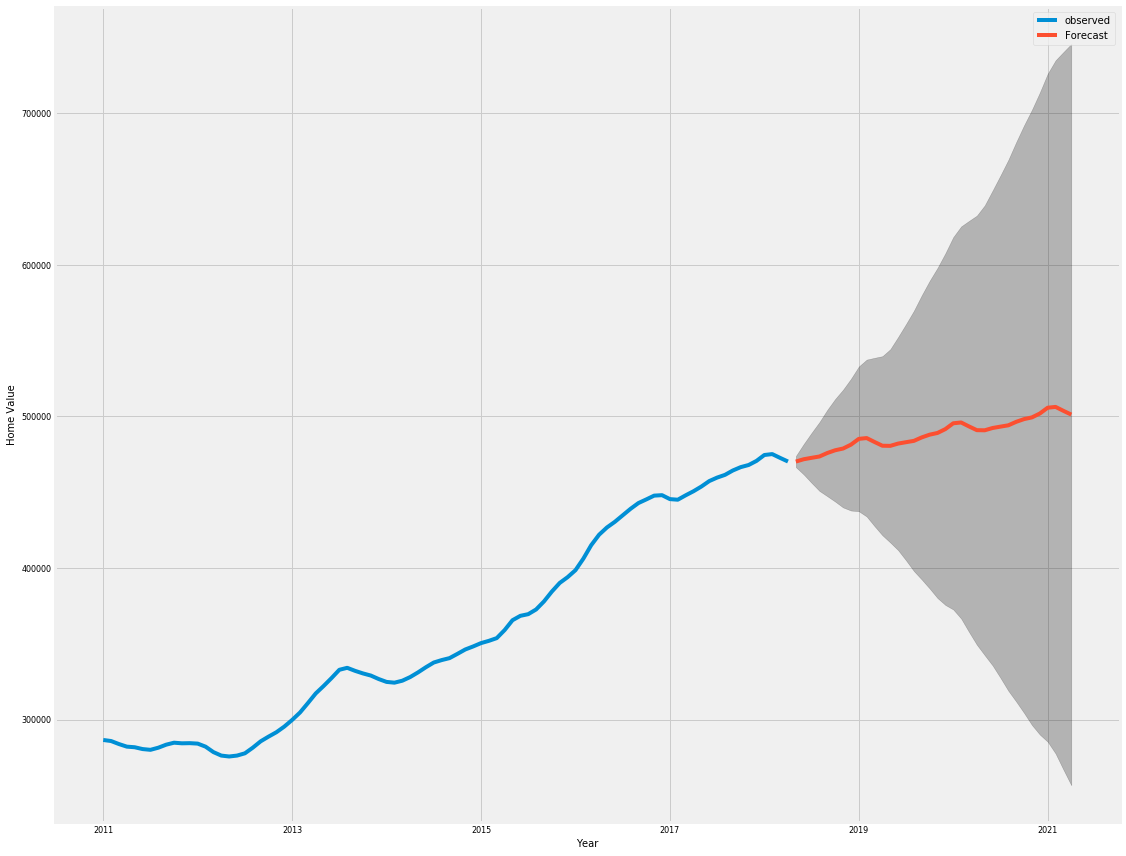

In [32]:
time_series_results(model_60647, 60647)

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                   88
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -521.111
Date:                            Wed, 23 Oct 2019   AIC                           1052.221
Time:                                    17:30:09   BIC                           1062.776
Sample:                                01-01-2011   HQIC                          1056.358
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8371      0.101      8.305      0.000       0.640       1.035
ma.L1          0.8357      0.087   

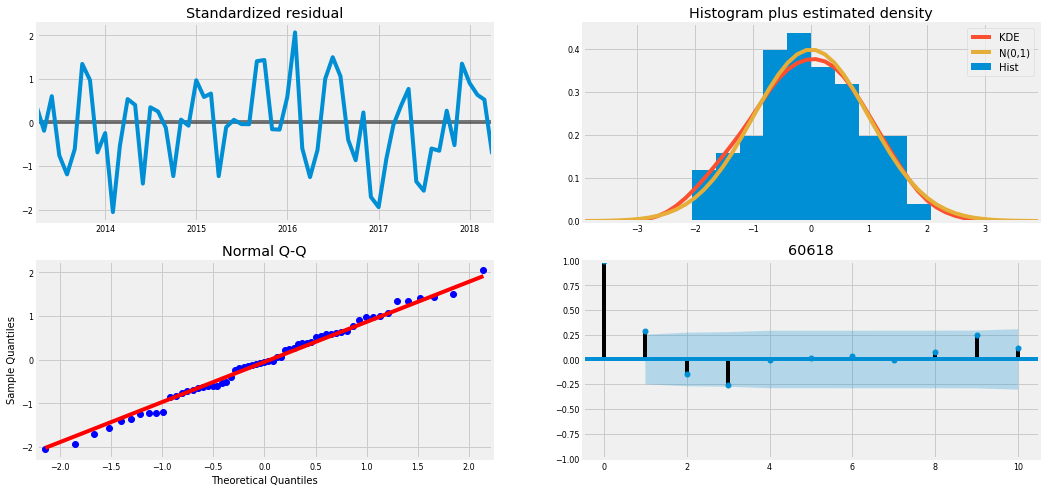

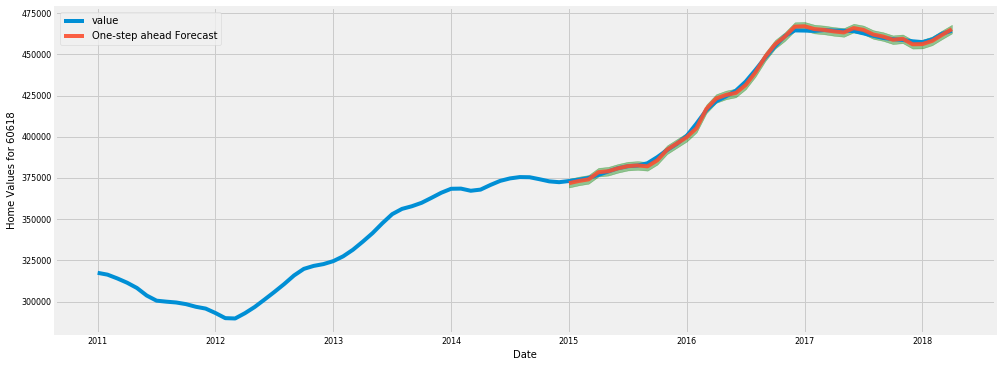

The Mean Squared Error of our forecasts for 60618 is 1654888.72


The Root Mean Squared Error of our forecasts for 60618 is 1286.42




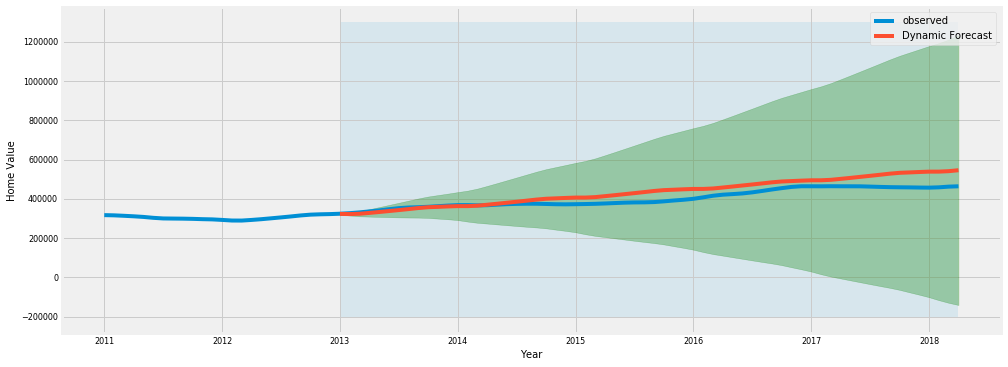

The Mean Squared Error of our forecasts for 60618 is 1727006518.51


The Root Mean Squared Error of our forecasts for 60618 is 41557.27




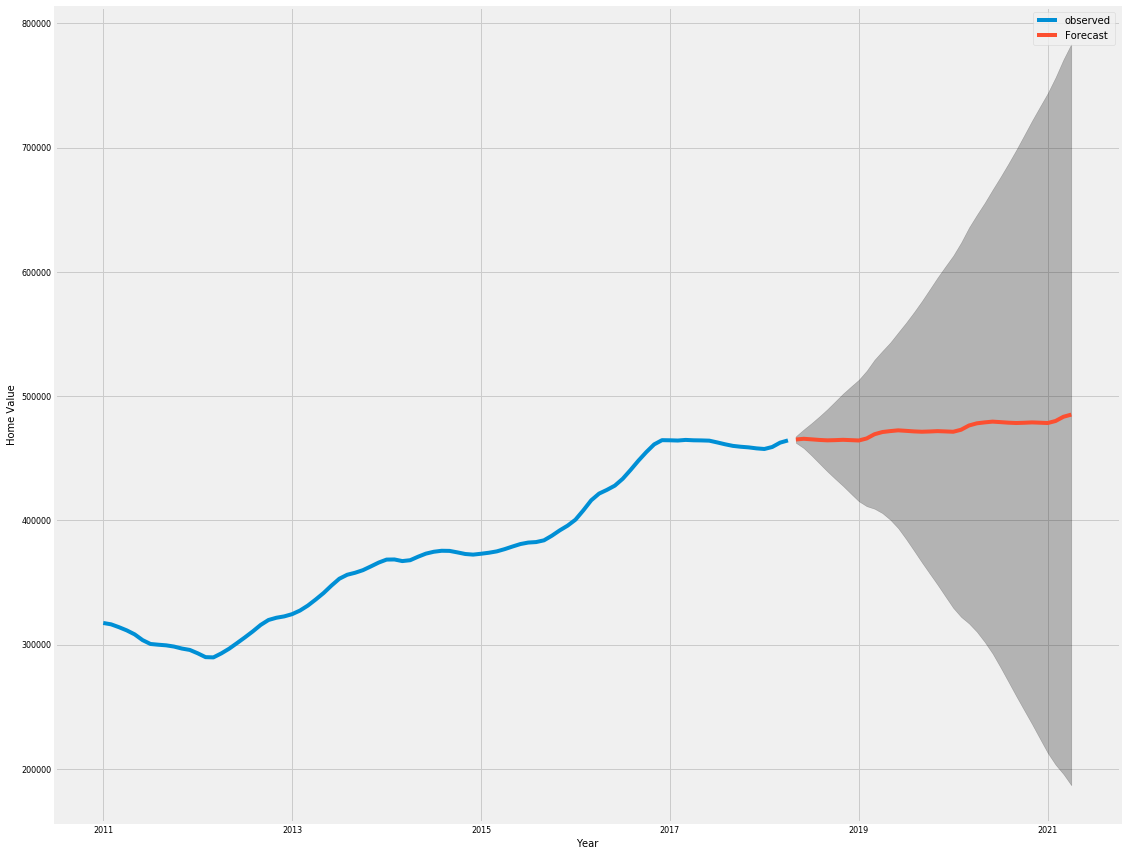

In [33]:
time_series_results(model_60618, 60618)

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                   88
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -521.639
Date:                            Wed, 23 Oct 2019   AIC                           1053.279
Time:                                    17:30:11   BIC                           1063.833
Sample:                                01-01-2011   HQIC                          1057.415
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7367      0.116      6.355      0.000       0.509       0.964
ma.L1          0.7397      0.114   

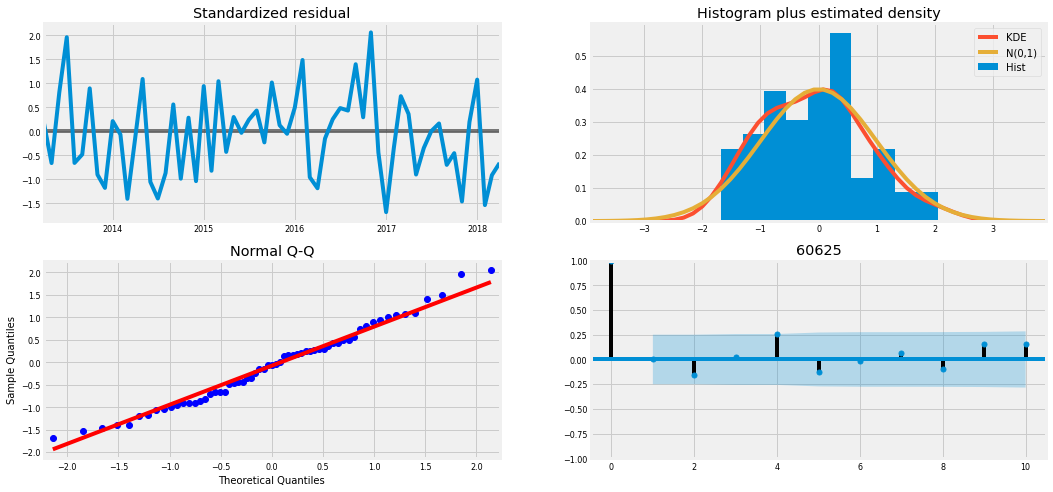

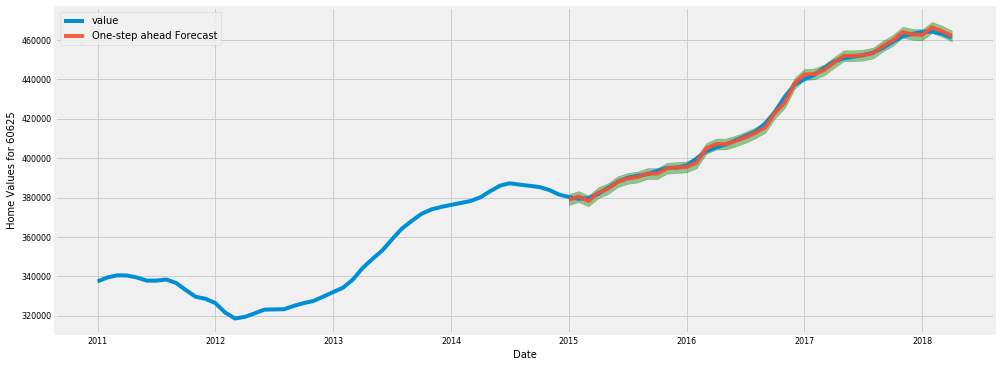

The Mean Squared Error of our forecasts for 60625 is 1407778.16


The Root Mean Squared Error of our forecasts for 60625 is 1186.5




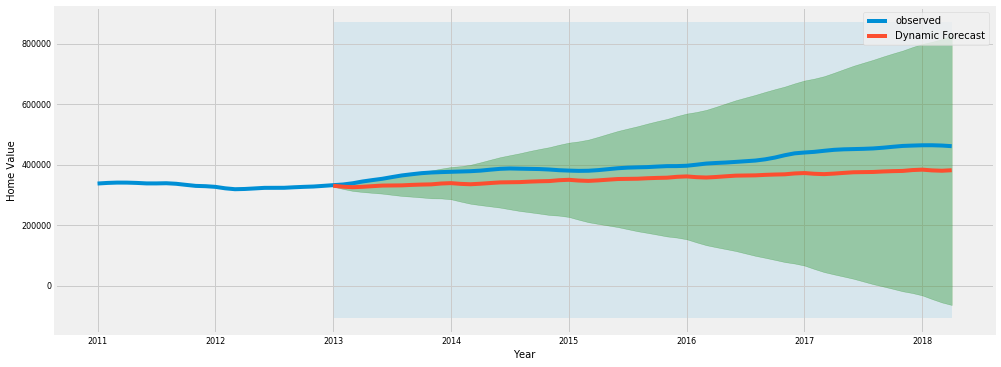

The Mean Squared Error of our forecasts for 60625 is 2715111460.05


The Root Mean Squared Error of our forecasts for 60625 is 52106.73




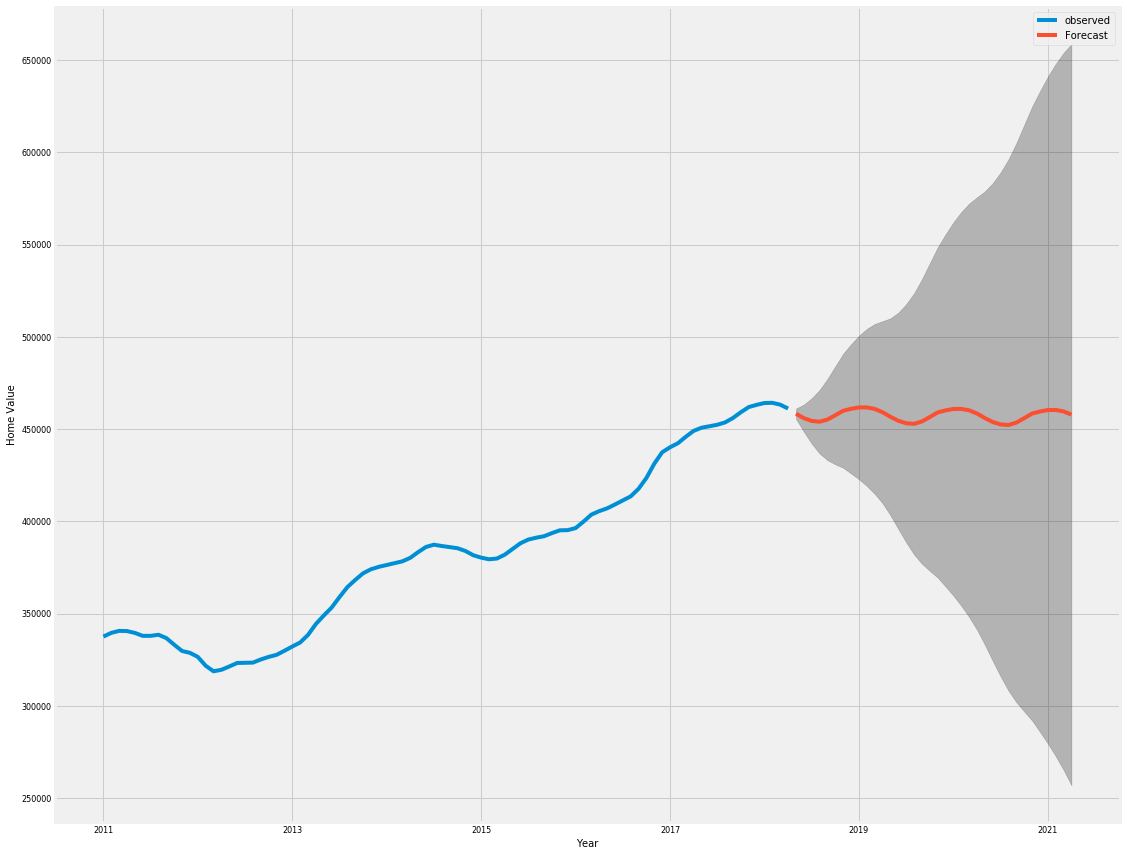

In [34]:
time_series_results(model_60625, 60625)

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                   88
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -519.940
Date:                            Wed, 23 Oct 2019   AIC                           1047.880
Time:                                    17:30:14   BIC                           1056.323
Sample:                                01-01-2011   HQIC                          1051.189
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7711      0.063     12.177      0.000       0.647       0.895
ma.L1          0.6305      0.102   

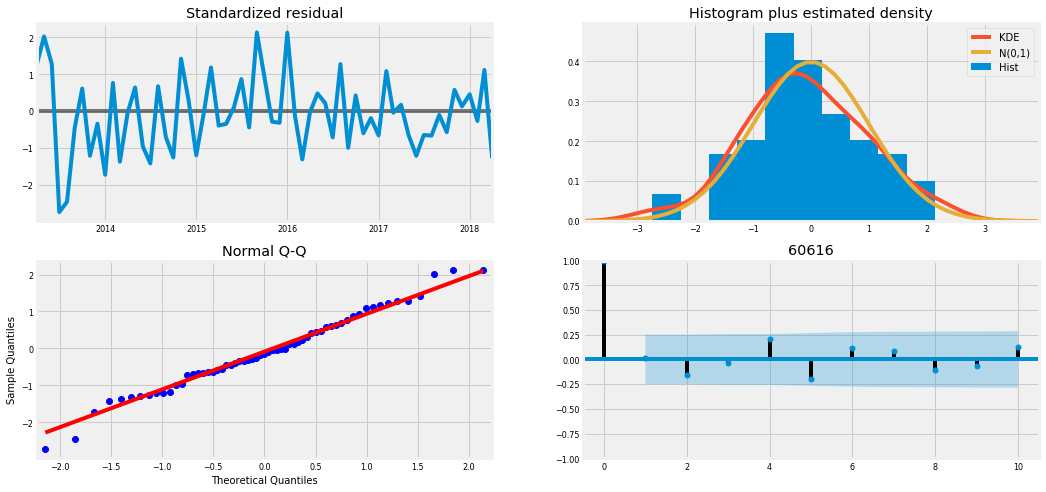

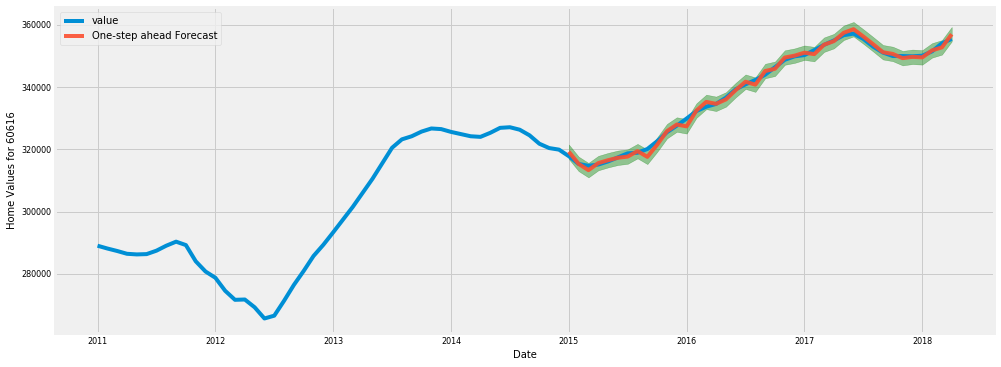

The Mean Squared Error of our forecasts for 60616 is 984851.44


The Root Mean Squared Error of our forecasts for 60616 is 992.4




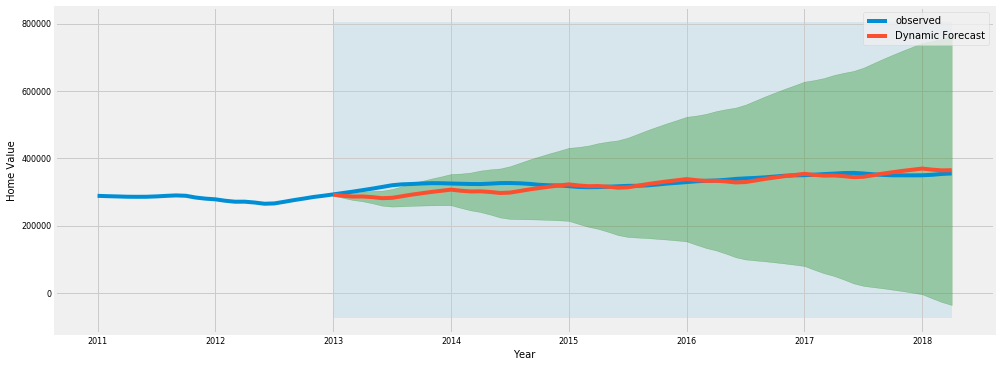

The Mean Squared Error of our forecasts for 60616 is 241466561.18


The Root Mean Squared Error of our forecasts for 60616 is 15539.19




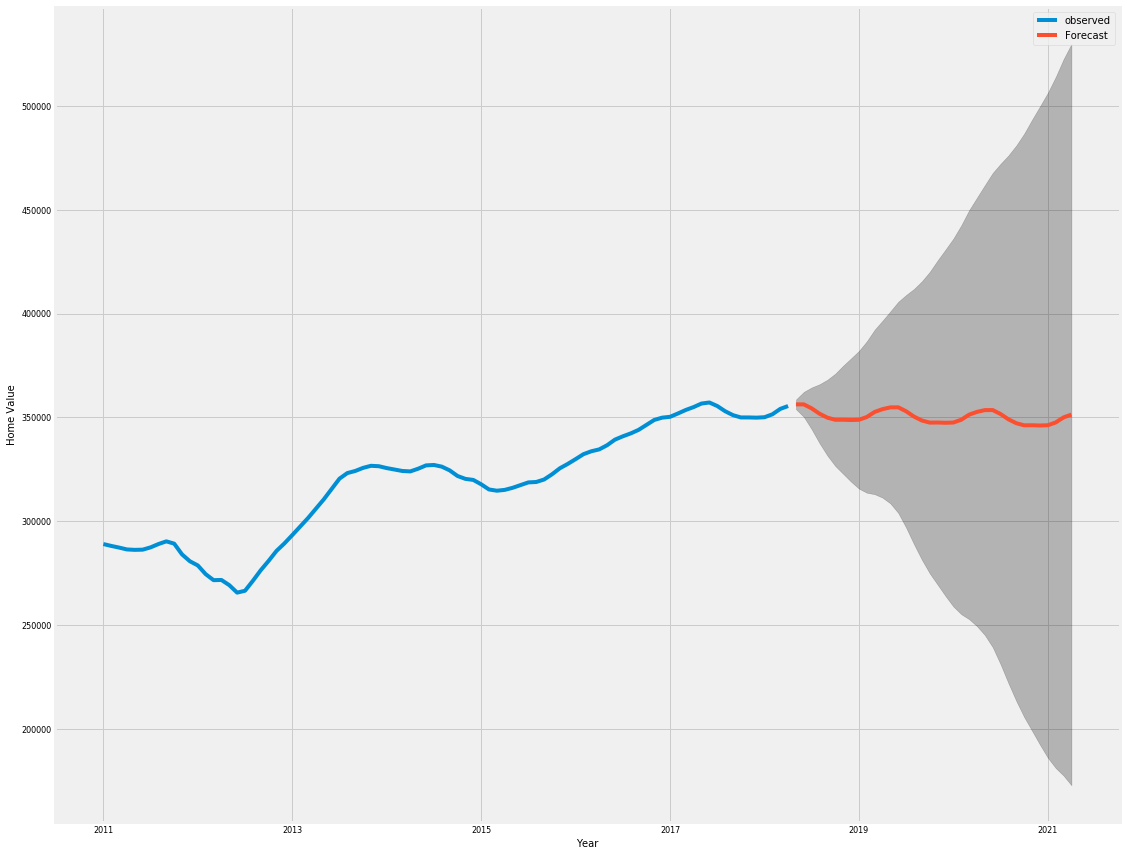

In [35]:
time_series_results(model_60616, 60616)

# Step 6: Interpreting Results

With stationary residuals, I believe the models performed well. Most predictions were within $2000 of the actual value which could be improved, but isn't terrible. 

# Step 7: Future Work

Assess both the zipcode's value and each individual property's value on additional criteria, such as proximity to parks, square footage, etcetera.

Continue to add values as they become available and refit the model with additional values. 